# HANK Tutorial

The package supports heterogeneous agent models with and without porfolio chocie (i.e., with one asset and two assets, respectively). Both examples are keept relatively close to the ones used in the [Sequence-Space Jacobian package](https://github.com/shade-econ/sequence-jacobian) for reasons of comparability. 

While for models without heterogenous agents, the calculation of the sequence-space jacobian for the nonlinear extended path is already speed and memmory optimized, this is not yet the case for HANK (but would be relatively straightforward). 

Start with some misc imports and load the package:

In [2]:
import matplotlib.pyplot as plt
import jax.numpy as jnp # use jax.numpy instead of normal numpy. Yes, this is one of the reasons why it is nice not to have all numpy objects imported on the lowest hirarchy
import econpizza as ep

# only necessary if you run this in a jupyter notebook:
%matplotlib inline 

## One-Asset HANK

The provided example is the same model as used by [Auclert et al., 2022](http://mattrognlie.com/sequence_space_jacobian.pdf), which is documented [in this notebook](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/hank.ipynb) (and in the appendix of their paper). 
There are some deviations. First, the NK-Phillips Curve is the conventional nonlinear Phillips Curve as derived from Rothemberg pricing,
 $$
     \psi\left(\frac{\pi_t}{\pi_{SS}} - 1\right)\frac{\pi_t}{\pi_{SS}} = (1-\theta) + \theta w_t + E_t\left\{ \psi \frac{\pi_{t+1}}{R_t}\left(\frac{\pi_{t+1}}{\pi_{SS}} - 1\right) \frac{\pi_{t+1}}{\pi_{SS}}\frac{Y^p_{t+1}}{Y^p_t}\right\},
 $$
 where the inverse real rate $\frac{\pi_{t+1}}{R_t}$ is used to avoid a representative household discount factor (e.g, $\\beta_{t+1} \frac{C_t}{C_{t+1}}$.
 
Second, the central bank sets the *shadow rate* to follow a conventional monetary policy rule with interest rate inertia,
$$
    R_{s,t} = \left[R^*\left(\frac{\pi_t}{\pi_{SS}}\right)^{\phi_\pi} \left(\frac{Y_t}{Y_{t-1}}\right)^{\phi_y}\right]^{1-\rho} R_{s,t-1}^\rho,
$$

and the actual nominal interest rate equals this *shadow rate* subject to the zero lower bound on nominal interest rates,
$$
R_t = \max\left\{1, R_{s,t}\right\}
$$

Details can be found in the section on the `yaml` file [above](https://econpizza.readthedocs.io/en/latest/tutorial.html#the-yaml-file>).

Load the example file:

In [2]:
from econpizza import example_hank

`example_hank` is nothing else than the path to the yaml file we discussed before:

In [3]:
print(example_hank)

/home/gboehl/github/econpizza/econpizza/examples/hank.yaml


Parse the example hank model from the yaml and compile the model:

In [4]:
# parse model
mod_dict = ep.parse(example_hank)
# compile the model
mod = ep.load(mod_dict)

(load:) Parsing done.


The first step creates a raw dictionary from the yaml. The second translates everything to a model instance with compiled and tested functions. If something specific in your model does not work, you should have been informed by now.

Lets continue with the steady state:

In [5]:
stst_result = mod.solve_stst()

    Iteration   1 | max error 7.45e-01 | lapsed 4.4934
    Iteration   2 | max error 1.74e-01 | lapsed 4.9535
    Iteration   3 | max error 8.49e-02 | lapsed 5.5002
    Iteration   4 | max error 1.42e-02 | lapsed 5.9926
    Iteration   5 | max error 7.03e-08 | lapsed 6.3992
    Iteration   6 | max error 5.84e-11 | lapsed 6.7755
(solve_stst:) Steady state error is 7.06e-08. The solution converged. Jacobian has rank 12 for 18 variables (6 fixed). 


By default, the final message is rather verbose. The rank of the Jacobian is important because quite often, the steady state is indetermined and you need to fix some steady state values. Econpizza can deal with that by using the Pseudoinverse during the Newton steps. Fixing some of the variables is also what I did here. Since the function has 12 degrees of freedom and 6 fixed variables for a total of 18 variables, we're fine and the steady state solver nicely converges.

The resulting `stst_result` is similar to the return object from `scipy.optimize.root` and contains all sorts of nice information to help you debugging if you have problems finding the steady state:

In [6]:
print(stst_result.keys())

dict_keys(['success', 'message', 'x', 'niter', 'fun', 'jac', 'det'])


In [7]:
print(stst_result['fun']) # the steady state function at the solution x

[-7.05779737e-08  0.00000000e+00  0.00000000e+00  3.52889034e-08
 -7.05778066e-08  3.52889034e-08  7.05779755e-08 -1.22124533e-14
 -6.69930778e-12 -3.34962573e-11  0.00000000e+00  7.05778066e-08
  1.41213263e-10 -5.88147842e-08  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


The Pizza automatically stores the steady state values as a dictionary in the model object:

In [8]:
mod['stst']

{'B': DeviceArray(5.6, dtype=float64),
 'beta': DeviceArray(0.98505158, dtype=float64),
 'C': DeviceArray(1.00000007, dtype=float64),
 'Div': DeviceArray(0.16666656, dtype=float64),
 'L': DeviceArray(1., dtype=float64),
 'pi': DeviceArray(1., dtype=float64),
 'R': DeviceArray(1.002, dtype=float64),
 'Rn': DeviceArray(1.002, dtype=float64),
 'Rs': DeviceArray(1.002, dtype=float64),
 'Rstar': DeviceArray(1.002, dtype=float64),
 'Tax': DeviceArray(0.01120007, dtype=float64),
 'Top10A': DeviceArray(0.42605587, dtype=float64),
 'Top10C': DeviceArray(0.29537923, dtype=float64),
 'vphi': DeviceArray(0.78656264, dtype=float64),
 'w': DeviceArray(0.83333333, dtype=float64),
 'Y': DeviceArray(1., dtype=float64),
 'Yprod': DeviceArray(0.99999996, dtype=float64),
 'Z': DeviceArray(1., dtype=float64)}

Let us, out of curiousity, have a look at the steady state distribution. It is stored under `mod['steady_state']`. Note that at the same location, also steady state `decisions` (the value function) are stored.

In [9]:
dist = mod['steady_state']['distributions'][0]
grid = mod['context']['a_grid']

Under the dict behind the `context` keyword, many other model specific variables are stored. Better have a look youself if you care. Lets plot the distribution:

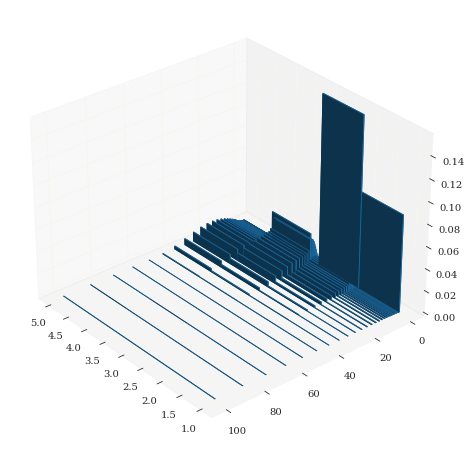

In [10]:
from grgrlib import grbar3d # a nice backend to 3D-plots with matplotlib

ax, _ = grbar3d(dist, xedges=jnp.arange(1,5), yedges=grid, figsize=(12,8), depth=.5) # create 3D plot
ax.view_init(azim=140) # rotate

Nice. Okay, let's continue to calculate some impulse response functions. We'll have a look at a shock to the households' discount factor $\beta$. Take the steady state as the initial value, and alter the value of $\beta$:

In [11]:
# this is a dict containing the steady state values
x0 = mod['stst'].copy()
# setting a shock on the discount factor
x0['beta'] = 0.99

Find the IRFs:

In [12]:
xst, _, flags = mod.find_stack(x0.values(), horizon=100, tol=1e-8)

(find_path_stacked:) Solving stack (size: 1800)...
    Iteration   1 | max error 4.01e-02 | lapsed 6.7726
    Iteration   2 | max error 4.64e-03 | lapsed 9.4682
    Iteration   3 | max error 9.58e-06 | lapsed 12.0850
(find_path_stacked:) Stacking done after 17.596 seconds. The solution converged.


That went smoothly. Again, you will get meaningful and (hopefully) infomative final messages. Let's plot only a few of the variables for space restrictions: output $y_t$ (`Y`), inflation $\pi_t$ (`pi`), the nominal interst rate $R_t$ (`Rn`), and the percentage share of wealth held by the top-10% richest, `Top10A`.

([<Figure size 576x432 with 4 Axes>],
 [<AxesSubplot:title={'center':'Y'}>,
  <AxesSubplot:title={'center':'pi'}>,
  <AxesSubplot:title={'center':'Rn'}>,
  <AxesSubplot:title={'center':'Top10A'}>],
 [[[<matplotlib.lines.Line2D at 0x7fe1742656f0>],
   [<matplotlib.lines.Line2D at 0x7fe1742662c0>]]])

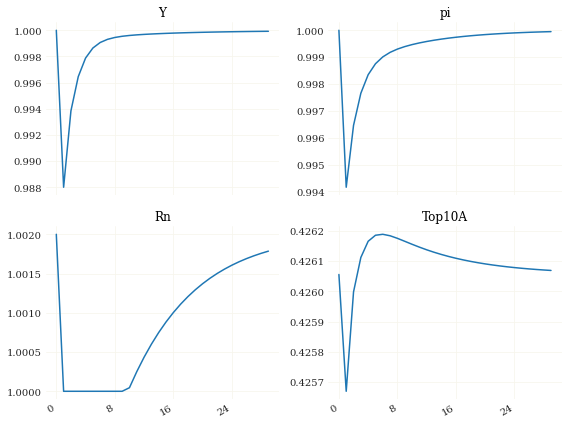

In [13]:
from grgrlib import grplot # a nice backend for batch plotting with matplotlib

# this is how all aggregate variables could be plotted:
#grplot(xst[:30], labels=mod['variables']) 

variables = 'Y', 'pi', 'Rn', 'Top10A'
inds = [mod['variables'].index(v) for v in variables] # get indices of variables

grplot(xst[:30, inds], labels=variables)

See how the effective lower bound is binding for 10 periods and the endogenous distribution adjusts accordingly. 


## Two-Asset HANK

This second example is the two-asset HANK model from [Auclert et al., 2022](http://mattrognlie.com/sequence_space_jacobian.pdf), which is documented [here](https://github.com/shade-econ/sequence-jacobian/blob/master/notebooks/two_asset.ipynb).

There are, again, some deviations. First, the NK-Phillips Curve is the conventional nonlinear Phillips Curve as derived from Rothemberg pricing,
 $$
     \psi\left(\frac{\pi_t}{\pi_{SS}} - 1\right)\frac{\pi_t}{\pi_{SS}} = (1-\theta) + \theta w_t + E_t\left\{ \psi \frac{\pi_{t+1}}{R_t}\left(\frac{\pi_{t+1}}{\pi_{SS}} - 1\right) \frac{\pi_{t+1}}{\pi_{SS}}\frac{Y^p_{t+1}}{Y^p_t}\right\},
 $$
 where the inverse real rate $\frac{\pi_{t+1}}{R_t}$ is used to avoid a representative household discount factor (e.g, $\\beta_{t+1} \frac{C_t}{C_{t+1}}$.
 
Second, the central bank sets the nominal interest rate to follow a conventional monetary policy rule with interest rate inertia,
$$
    R_{s,t} = \left[R^*\left(\frac{\pi_t}{\pi_{SS}}\right)^{\phi_\pi} \left(\frac{Y_t}{Y_{t-1}}\right)^{\phi_y}\right]^{1-\rho} R_{s,t-1}^\rho.
$$

$$

Details can be found in the section on the `yaml` file [above](https://econpizza.readthedocs.io/en/latest/tutorial.html#the-yaml-file>).

This ends this short tutorial. Further details on the implementation of heterogeneous agent models are given [in the technical section](https://econpizza.readthedocs.io/en/latest/method.html).